In [1]:
import os
from pathlib import Path

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import geopandas as gpd

import fiona
import rasterio
import rasterio.mask
import rasterio as rio
from rasterio.plot import *
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import Polygon

import earthpy.spatial as es

In [2]:
# Create paths to files

data_dir = os.path.join(str(Path.home()), "Desktop", "drought-tracker", "data")

path_to_josephine = os.path.join(data_dir, "TIGER", "josephine.geojson")

path_to_nlcd = os.path.join(data_dir, "NLCD", "NLCD_2016_Land_Cover_L48_20190424.img")

nlcd_clipped_path = os.path.join(data_dir, "created", "nlcd_clipped.tif")

nlcd_clip_proj_path = os.path.join(data_dir, "created", "nlcd_clip_proj.tif")

In [ ]:
# Load josephine county into gdf
josephine = gpd.read_file(path_to_josephine)

# Find projection of raster
with rio.open(path_to_nlcd) as src:
    src_meta = src.meta
    
# Convert Josephine to same CRS to clip
josephine_reproj = josephine.to_crs(src_meta['crs'])

C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [4]:
# Clip raster
clip_shape = [josephine_reproj.geometry[0]]


with rio.open(path_to_nlcd) as src:
    out_image, out_transform = rio.mask.mask(src, clip_shape, crop=True)
    out_meta = src.meta

In [5]:
# Eliminate "layer"
out_image = out_image[0, :, :]

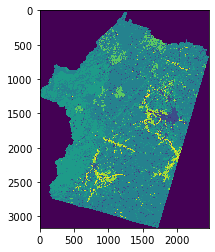

In [6]:
# See image
fig, ax = plt.subplots()
ax.imshow(out_image)
#josephine_reproj.plot(ax=ax)

In [7]:
# Save out_image
with rio.open(nlcd_clipped_path, 'w', **out_meta) as outf:
    outf.write(out_image, 1)

In [9]:
dst_crs = "EPSG:4326"


# Clip raster
clip_shape = [josephine_reproj.geometry[0]]


with rio.open(nlcd_clipped_path) as src:

    transform, width, height = calculate_default_transform(src.crs,
                                                           dst_crs,
                                                           src.width,
                                                           src.height,
                                                           *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height})

    with rio.open(nlcd_clip_proj_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
# Open cropped image
with rio.open(nlcd_clip_proj_path) as src:
    nlcd = src.read(1)

In [ ]:
nlcd_crop = nlcd_crop[0]

In [ ]:
farms = ma.masked_where(nlcd_crop != 81, nlcd_crop)

In [ ]:
farms_extent = plotting_extent(farms, nlcd_crop_meta['transform'])
farms_extent

In [ ]:
fig, ax = plt.subplots()

ax.imshow(farms, extent=farms_extent)
josephine.plot(ax=ax, color="green", alpha=0.2)

plt.show()

In [ ]:
path_to_master_gdf = os.path.join(home, "Desktop", "drought-tracker", "data", "created", "josephine_master.geojson")
master_gdf = gpd.read_file(path_to_master_gdf)

In [ ]:
master_gdf = master_gdf.to_crs(josephine.crs)

In [ ]:
fig, (norms, t_2, t_1, t) = plt.subplots(1, 4, figsize=(15, 5))

fig.suptitle("Drought Extent in relation to Cropland in Josephine County, OR\n" +
             "from P/PET(May 01 - Oct 31)")

norms.set_title("Norms from 2009 - 2019")
master_gdf[:1].plot(ax=norms, color="none", edgecolor='black', zorder=2)
josephine.plot(ax=norms, color='green')
norms.imshow(farms, extent=farms_extent, zorder=3)
norms.set_axis_off()

t_2.set_title("2016")
master_gdf[3:4].plot(ax=t_2, color="none", edgecolor='orange', zorder=2)
josephine.plot(ax=t_2, color='green')
t_2.imshow(farms, extent=farms_extent, zorder=3)
t_2.set_axis_off()

t_1.set_title("2018")
master_gdf[5:6].plot(ax=t_1, color="none", edgecolor='orange', zorder=2)
josephine.plot(ax=t_1, color='green')
t_1.imshow(farms, extent=farms_extent, zorder=3)
t_1.set_axis_off()

t.set_title("2019")
master_gdf[-1:].plot(ax=t, color="none", edgecolor='orange', zorder=2)
josephine.plot(ax=t, color='green')
t.imshow(farms, extent=farms_extent, zorder=3)
t.set_axis_off()

In [ ]:
nlcd_crop_meta